In [6]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from biasonly import RecommendationBias
from implicit import RecommendationImplicit
from itemtime import RecommendationItem
from itemtimetime import RecommendationItemTT
from usertime import RecommendationUser
#from usertimetime import RecommendationUserTT
from vector import RecommendationVector
from logitboostmodel import LogitBoost,Classifier2,EnsembleModel
import random
np.random.seed(42)
random.seed(42)

In [1]:
import os
print(os.getcwdb())

b'/content'


In [2]:
cd /content/drive/MyDrive/RecomendModel

/content/drive/MyDrive/RecomendModel


In [7]:
df = pd.read_csv('/content/drive/MyDrive/RecomendModel/df_Amazon .csv')

In [8]:
df=df.drop(['Unnamed: 0'],axis=1)

In [9]:
df['overall']=np.where(df['overall']==1,0,df['overall'])
df['overall']=np.where(df['overall']==2,1,df['overall'])
df['overall']=np.where(df['overall']==3,2,df['overall'])
df['overall']=np.where(df['overall']==4,3,df['overall'])
df['overall']=np.where(df['overall']==5,4,df['overall'])

In [10]:
data2=df[['ReviewDay','ITBin','userID','itemID','TDayCat']]

In [11]:
df["summary"] = df["summary"].astype(str)

In [12]:
# Tokenize sentences
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
sentences = df["summary"].tolist()
#sentences = Amaz["summary"].tolist()
tokenized_sentences = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")


# Extract CLS embeddings
model = BertModel.from_pretrained("bert-base-uncased")
with torch.no_grad():
    cls_embeddings = model(**tokenized_sentences).last_hidden_state[:, 0, :]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [13]:
 # CLS BERT derived vectors
 cls_embeddings

tensor([[-0.1380,  0.0338, -0.5545,  ..., -0.1394, -0.0842,  0.6636],
        [-0.3701,  0.3185, -0.1188,  ..., -0.4376,  0.0060,  0.2965],
        [-0.1039,  0.2654,  0.2127,  ..., -0.2849, -0.0933,  0.0509],
        ...,
        [-0.6113, -0.1417, -0.2610,  ..., -0.6473,  0.4008,  0.2865],
        [ 0.2018,  0.3788, -0.2881,  ..., -0.3740,  0.6230,  0.2229],
        [-0.0099,  0.0702,  0.1156,  ..., -0.3047,  0.1354,  0.2751]])

In [14]:
cls= pd.DataFrame(cls_embeddings) #cls.drop(['Unnamed: 0'],axis=1)

In [15]:
cls

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.138028,0.033809,-0.554459,0.192903,-0.629124,-0.041640,0.351486,0.167370,0.476593,-0.112401,...,-0.433822,0.089979,0.419347,-0.147671,-0.325074,0.028495,-0.228050,-0.139382,-0.084243,0.663608
1,-0.370146,0.318539,-0.118825,0.048926,-0.058745,-0.297229,-0.028243,0.673991,0.253881,-0.406400,...,0.269471,-0.302399,0.410748,0.193239,0.362636,-0.138213,-0.059112,-0.437629,0.005964,0.296505
2,-0.103927,0.265396,0.212706,0.210225,-0.000857,-0.489633,0.052869,0.539365,0.433922,-0.254267,...,0.176950,-0.356101,-0.004430,0.204198,-0.002048,0.045187,-0.050891,-0.284948,-0.093263,0.050871
3,0.021176,0.207097,0.156271,-0.042908,-0.036904,-0.221278,0.084874,0.343427,0.191620,-0.049803,...,0.012147,-0.195435,0.040209,0.109033,0.024755,-0.039845,-0.013114,-0.085197,-0.005787,0.234130
4,-0.065721,0.120295,0.095614,0.194575,-0.411095,-0.010173,0.572881,0.530922,0.520302,-0.249369,...,0.379114,-0.149003,0.273338,-0.339468,-0.157545,-0.099876,-0.359206,-0.258411,0.211845,0.409635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28793,0.134654,0.105867,-0.001024,-0.051100,-0.433187,-0.520722,0.452167,0.540153,0.002177,0.118052,...,-0.081764,-0.148707,0.106932,-0.125365,0.089069,-0.151641,-0.360482,-0.201743,0.255315,0.268791
28794,-0.286008,0.243789,-0.492974,-0.153268,-0.417692,-0.302831,0.213497,0.544462,-0.138743,0.053314,...,-0.448132,-0.167659,-0.025589,0.059512,-0.096840,-0.094660,-0.412263,-0.178131,0.309229,0.180568
28795,-0.611285,-0.141680,-0.260956,-0.379436,-0.359638,0.012850,0.338489,0.408950,-0.514686,0.177437,...,-0.196566,-0.118148,0.020325,-0.009978,0.356611,-0.271885,-0.071562,-0.647283,0.400788,0.286452
28796,0.201821,0.378838,-0.288092,-0.570803,-0.133705,-0.230764,0.408220,0.845409,0.376183,-0.460142,...,-0.297805,-0.237024,-0.170303,-0.293642,-0.102372,-0.095622,-0.150905,-0.374038,0.623017,0.222918


In [16]:
A=pd.concat([data2,pd.DataFrame(cls)],axis=1)

In [17]:
X = A
y= df["overall"]



# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=38)


In [18]:
# Define a list of tuples with model name and corresponding factory function.
# Each factory function returns a new instance of the respective classifier1 model.
models = [
    ("biasonly", lambda: RecommendationBias()),
    ("Vector", lambda: RecommendationVector()),
    ("ItemT", lambda: RecommendationItem()),
    ("UserT", lambda: RecommendationUser()),
    ("ItemTTime", lambda: RecommendationItemTT()),
    ("Implicit", lambda: RecommendationImplicit())
]
#("UserTTime", lambda: RecommendationUserTT()),


In [19]:
 #Define feature subsets for the classifiers
feature_subset1 = list(range(5))  # Example feature indices for classifier 1
feature_subset2 = list(range(5, 773))  # Example feature indices for classifier 2

In [20]:
# ---------------------
# Containers for final test metrics (last iteration) for bar plots
# ---------------------
final_mse = []
final_accuracy = []
final_log_loss = []
model_names = []


Running LogitBoost with biasonly as classifier1...
Iteration 1/6 - MSE train: 0.5796, Accuracy train: 0.6849,Log Loss: 1.4891, Time Elapsed: 39.36s, Estimated Time Remaining: 196.82s
Iteration 2/6 - MSE train: 0.5793, Accuracy train: 0.6849,Log Loss: 1.3809, Time Elapsed: 76.13s, Estimated Time Remaining: 152.26s
Iteration 3/6 - MSE train: 0.5814, Accuracy train: 0.6847,Log Loss: 1.2858, Time Elapsed: 113.97s, Estimated Time Remaining: 113.97s
Iteration 4/6 - MSE train: 0.5883, Accuracy train: 0.6838,Log Loss: 1.2006, Time Elapsed: 152.43s, Estimated Time Remaining: 76.21s
Iteration 5/6 - MSE train: 0.5872, Accuracy train: 0.6838,Log Loss: 1.1280, Time Elapsed: 190.52s, Estimated Time Remaining: 38.10s
Iteration 6/6 - MSE train: 0.5869, Accuracy train: 0.6838,Log Loss: 1.0667, Time Elapsed: 229.00s, Estimated Time Remaining: 0.00s


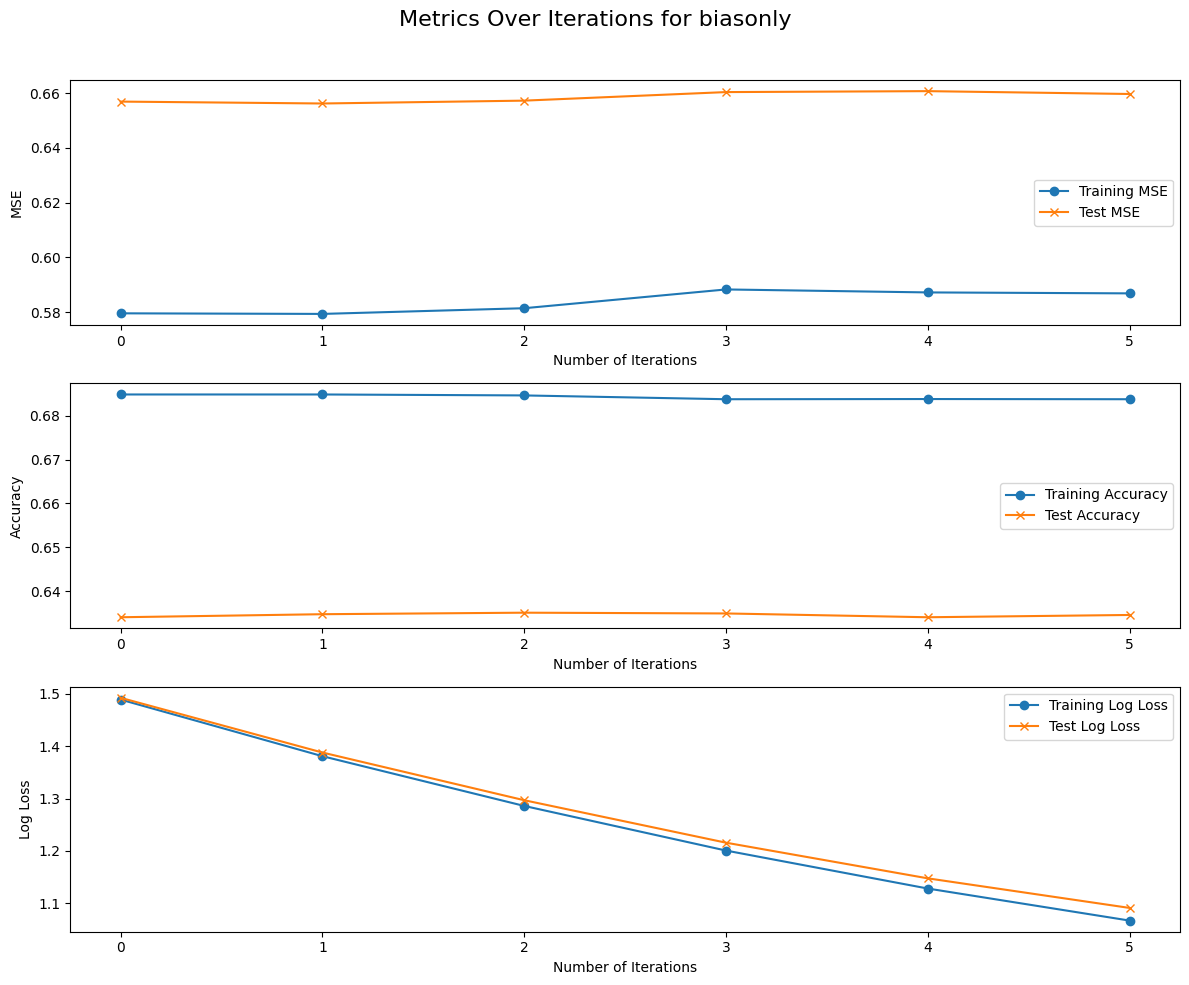


Running LogitBoost with Vector as classifier1...
Iteration 1/6 - MSE train: 0.5938, Accuracy train: 0.6829,Log Loss: 1.4879, Time Elapsed: 38.96s, Estimated Time Remaining: 194.81s
Iteration 2/6 - MSE train: 0.5896, Accuracy train: 0.6846,Log Loss: 1.3802, Time Elapsed: 77.26s, Estimated Time Remaining: 154.51s
Iteration 3/6 - MSE train: 0.5863, Accuracy train: 0.6850,Log Loss: 1.2850, Time Elapsed: 118.11s, Estimated Time Remaining: 118.11s
Iteration 4/6 - MSE train: 0.5844, Accuracy train: 0.6848,Log Loss: 1.2019, Time Elapsed: 158.42s, Estimated Time Remaining: 79.21s
Iteration 5/6 - MSE train: 0.5833, Accuracy train: 0.6846,Log Loss: 1.1300, Time Elapsed: 198.89s, Estimated Time Remaining: 39.78s
Iteration 6/6 - MSE train: 0.5832, Accuracy train: 0.6846,Log Loss: 1.0684, Time Elapsed: 239.34s, Estimated Time Remaining: 0.00s


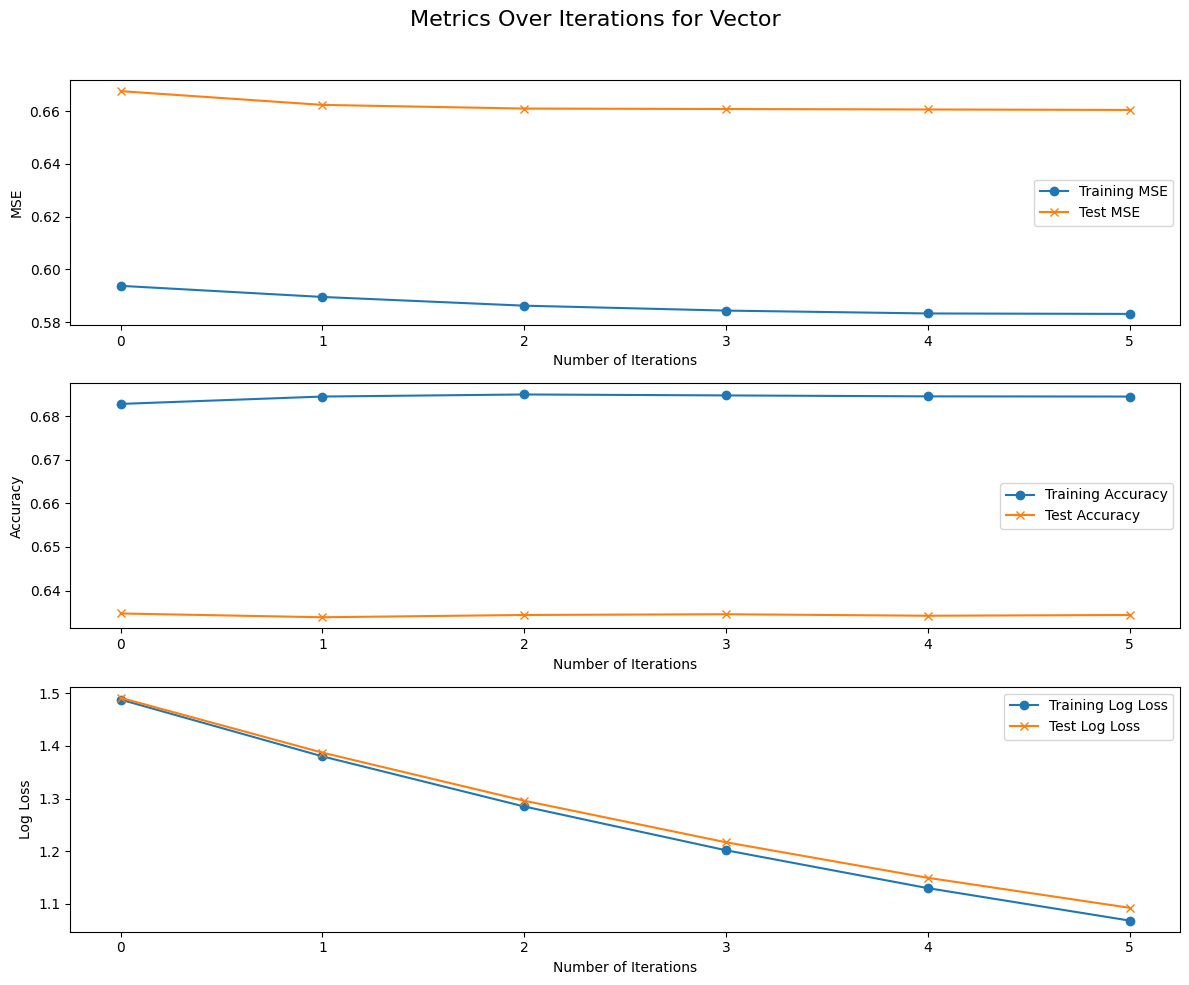


Running LogitBoost with ItemT as classifier1...
Iteration 1/6 - MSE train: 0.5757, Accuracy train: 0.6850,Log Loss: 1.4846, Time Elapsed: 40.89s, Estimated Time Remaining: 204.44s
Iteration 2/6 - MSE train: 0.5771, Accuracy train: 0.6847,Log Loss: 1.3746, Time Elapsed: 80.82s, Estimated Time Remaining: 161.63s
Iteration 3/6 - MSE train: 0.5873, Accuracy train: 0.6876,Log Loss: 1.2879, Time Elapsed: 120.43s, Estimated Time Remaining: 120.43s
Iteration 4/6 - MSE train: 0.5873, Accuracy train: 0.6875,Log Loss: 1.2053, Time Elapsed: 159.79s, Estimated Time Remaining: 79.89s
Iteration 5/6 - MSE train: 0.5920, Accuracy train: 0.6846,Log Loss: 1.1407, Time Elapsed: 199.53s, Estimated Time Remaining: 39.91s
Iteration 6/6 - MSE train: 0.5903, Accuracy train: 0.6860,Log Loss: 1.0763, Time Elapsed: 238.47s, Estimated Time Remaining: 0.00s


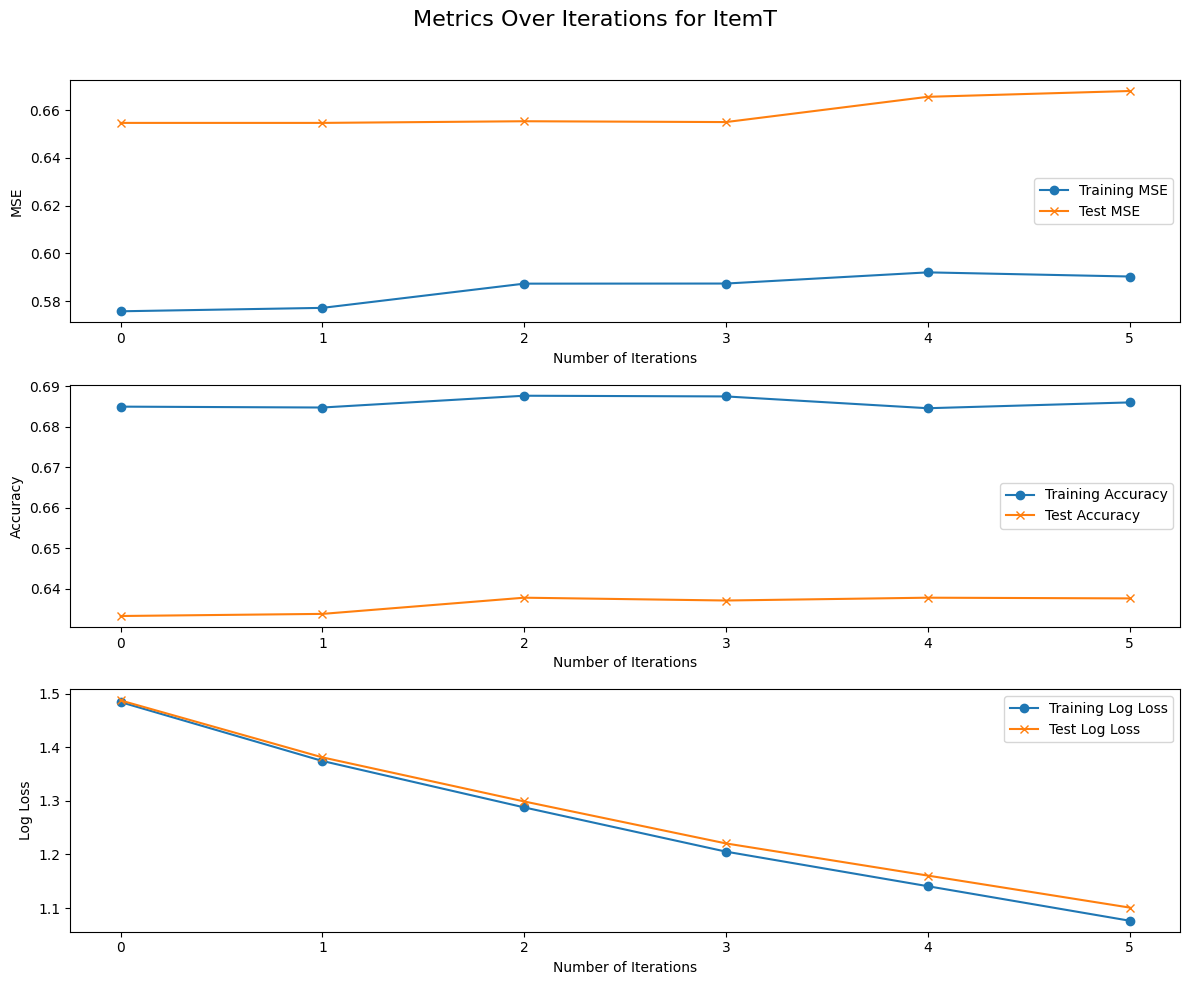


Running LogitBoost with UserT as classifier1...
Iteration 1/6 - MSE train: 0.6448, Accuracy train: 0.6588,Log Loss: 1.5023, Time Elapsed: 42.45s, Estimated Time Remaining: 212.27s
Iteration 2/6 - MSE train: 0.6159, Accuracy train: 0.6762,Log Loss: 1.3988, Time Elapsed: 84.45s, Estimated Time Remaining: 168.90s
Iteration 3/6 - MSE train: 0.6494, Accuracy train: 0.6794,Log Loss: 1.3268, Time Elapsed: 128.10s, Estimated Time Remaining: 128.10s
Iteration 4/6 - MSE train: 0.6748, Accuracy train: 0.6744,Log Loss: 1.2579, Time Elapsed: 171.34s, Estimated Time Remaining: 85.67s
Iteration 5/6 - MSE train: 0.6474, Accuracy train: 0.6789,Log Loss: 1.1816, Time Elapsed: 214.69s, Estimated Time Remaining: 42.94s
Iteration 6/6 - MSE train: 0.6382, Accuracy train: 0.6801,Log Loss: 1.1142, Time Elapsed: 260.16s, Estimated Time Remaining: 0.00s


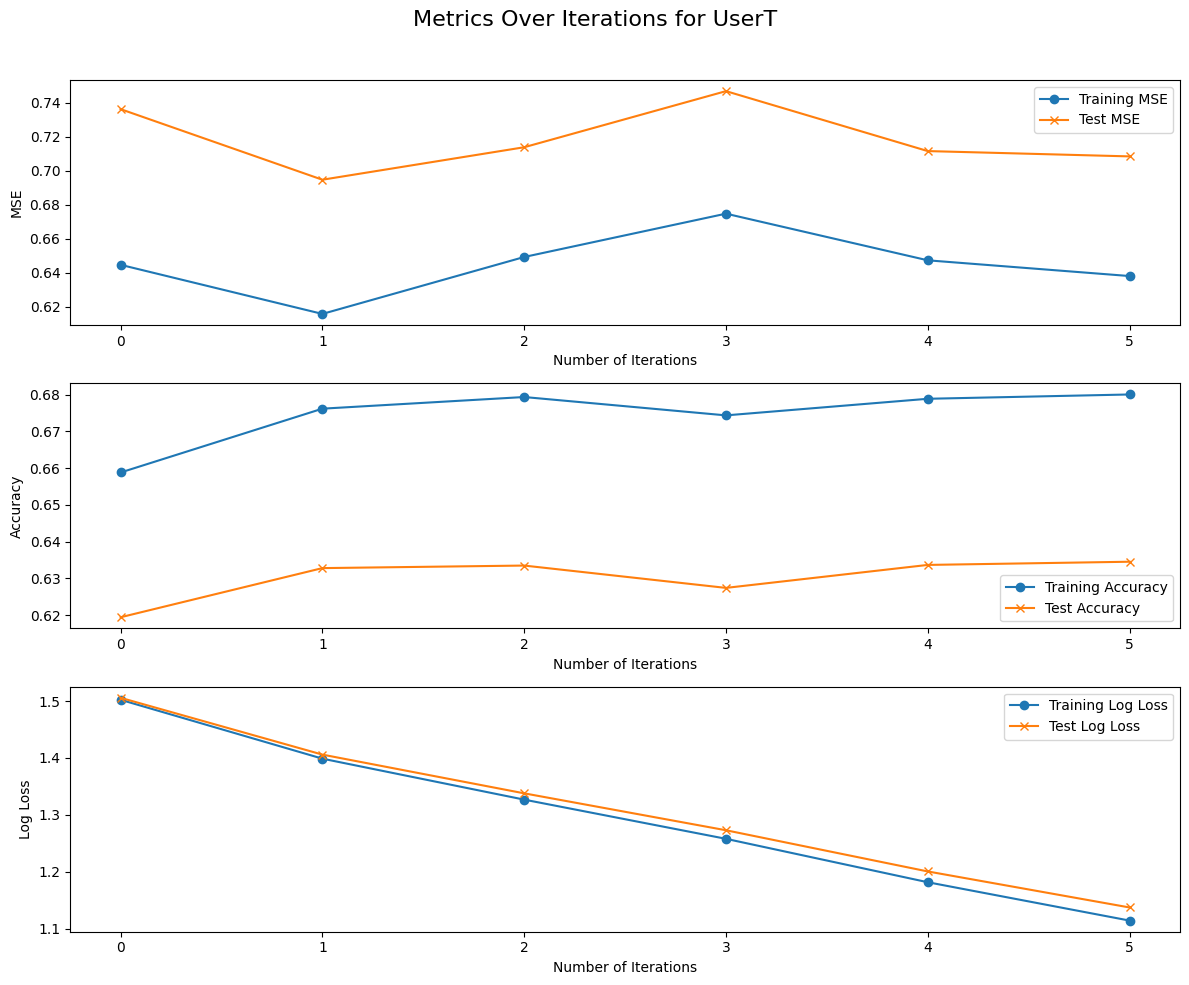


Running LogitBoost with ItemTTime as classifier1...
Iteration 1/6 - MSE train: 0.8912, Accuracy train: 0.6203,Log Loss: 1.5232, Time Elapsed: 42.51s, Estimated Time Remaining: 212.56s
Iteration 2/6 - MSE train: 0.7756, Accuracy train: 0.6601,Log Loss: 1.4288, Time Elapsed: 85.49s, Estimated Time Remaining: 170.98s
Iteration 3/6 - MSE train: 0.7600, Accuracy train: 0.6662,Log Loss: 1.3448, Time Elapsed: 129.44s, Estimated Time Remaining: 129.44s
Iteration 4/6 - MSE train: 0.7635, Accuracy train: 0.6662,Log Loss: 1.2728, Time Elapsed: 173.11s, Estimated Time Remaining: 86.55s
Iteration 5/6 - MSE train: 0.7752, Accuracy train: 0.6667,Log Loss: 1.2121, Time Elapsed: 216.25s, Estimated Time Remaining: 43.25s
Iteration 6/6 - MSE train: 0.7841, Accuracy train: 0.6652,Log Loss: 1.1603, Time Elapsed: 260.81s, Estimated Time Remaining: 0.00s


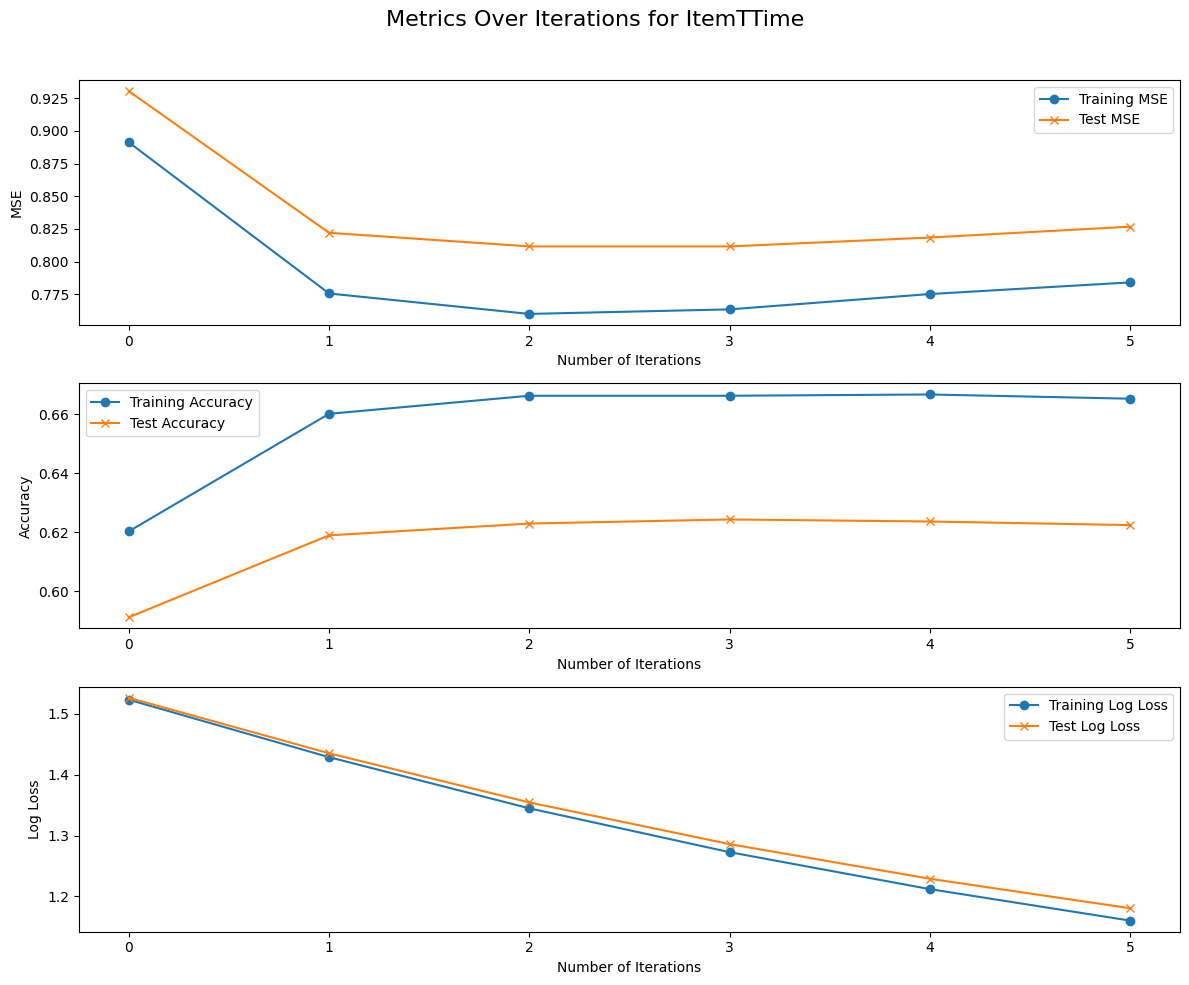


Running LogitBoost with Implicit as classifier1...
Iteration 1/6 - MSE train: 0.9254, Accuracy train: 0.6128,Log Loss: 1.5266, Time Elapsed: 138.05s, Estimated Time Remaining: 690.25s
Iteration 2/6 - MSE train: 0.9254, Accuracy train: 0.6128,Log Loss: 1.4504, Time Elapsed: 277.28s, Estimated Time Remaining: 554.56s
Iteration 3/6 - MSE train: 0.9254, Accuracy train: 0.6128,Log Loss: 1.3807, Time Elapsed: 415.65s, Estimated Time Remaining: 415.65s
Iteration 4/6 - MSE train: 0.9255, Accuracy train: 0.6127,Log Loss: 1.3173, Time Elapsed: 551.32s, Estimated Time Remaining: 275.66s
Iteration 5/6 - MSE train: 0.9255, Accuracy train: 0.6127,Log Loss: 1.2600, Time Elapsed: 686.21s, Estimated Time Remaining: 137.24s
Iteration 6/6 - MSE train: 0.9255, Accuracy train: 0.6127,Log Loss: 1.2085, Time Elapsed: 822.52s, Estimated Time Remaining: 0.00s


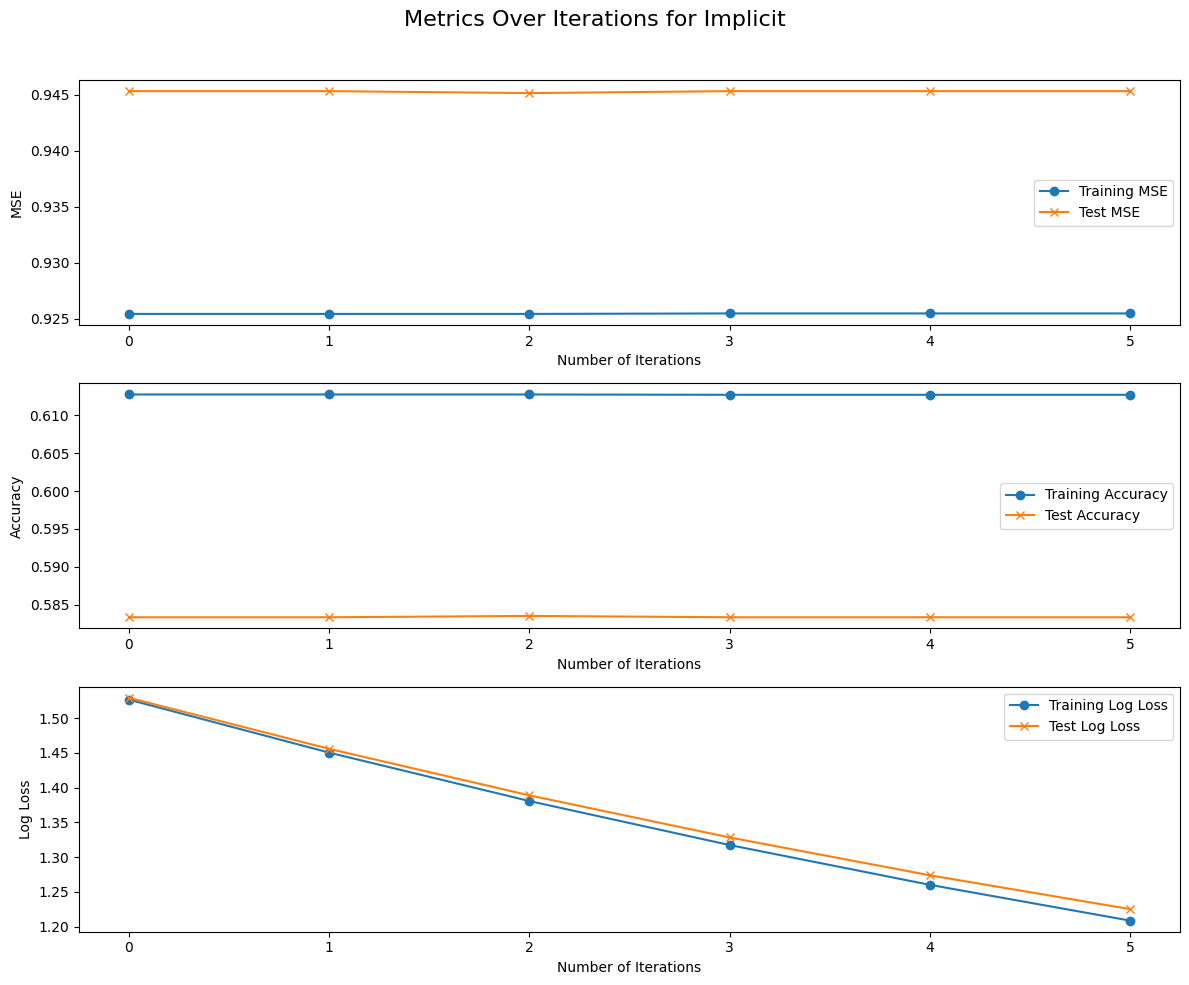

In [27]:
# Loop over each model and run experiments
for name, clf1_factory in models:
    print(f"\nRunning LogitBoost with {name} as classifier1...")
    logitboost = LogitBoost(n_estimators=6, learning_rate=0.02,
                            feature_subset1=feature_subset1,
                            feature_subset2=feature_subset2,
                            clf1_factory=clf1_factory)
    # Fit the model and get training metrics over iterations
    mse_train, accuracy_train, log_loss_train = logitboost.fit(X_train, y_train)
    # Get test metrics over iterations
    _, mse_test, accuracy_test, log_loss_test = logitboost.predict(X_test, y_test)

    # Store final (last iteration) test metrics for bar plot summary
    final_mse.append(mse_test[-1])
    final_accuracy.append(accuracy_test[-1])
    final_log_loss.append(log_loss_test[-1])
    model_names.append(name)
     # ---------------------
    # Plot train vs. test metrics over iterations for this model
    # ---------------------
    plt.figure(figsize=(12, 10))
    plt.suptitle(f"Metrics Over Iterations for {name}", fontsize=16)

    plt.subplot(3, 1, 1)
    plt.plot(mse_train, label='Training MSE', marker='o')
    plt.plot(mse_test, label='Test MSE', marker='x')
    plt.xlabel('Number of Iterations')
    plt.ylabel('MSE')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(accuracy_train, label='Training Accuracy', marker='o')
    plt.plot(accuracy_test, label='Test Accuracy', marker='x')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(log_loss_train, label='Training Log Loss', marker='o')
    plt.plot(log_loss_test, label='Test Log Loss', marker='x')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Log Loss')
    plt.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


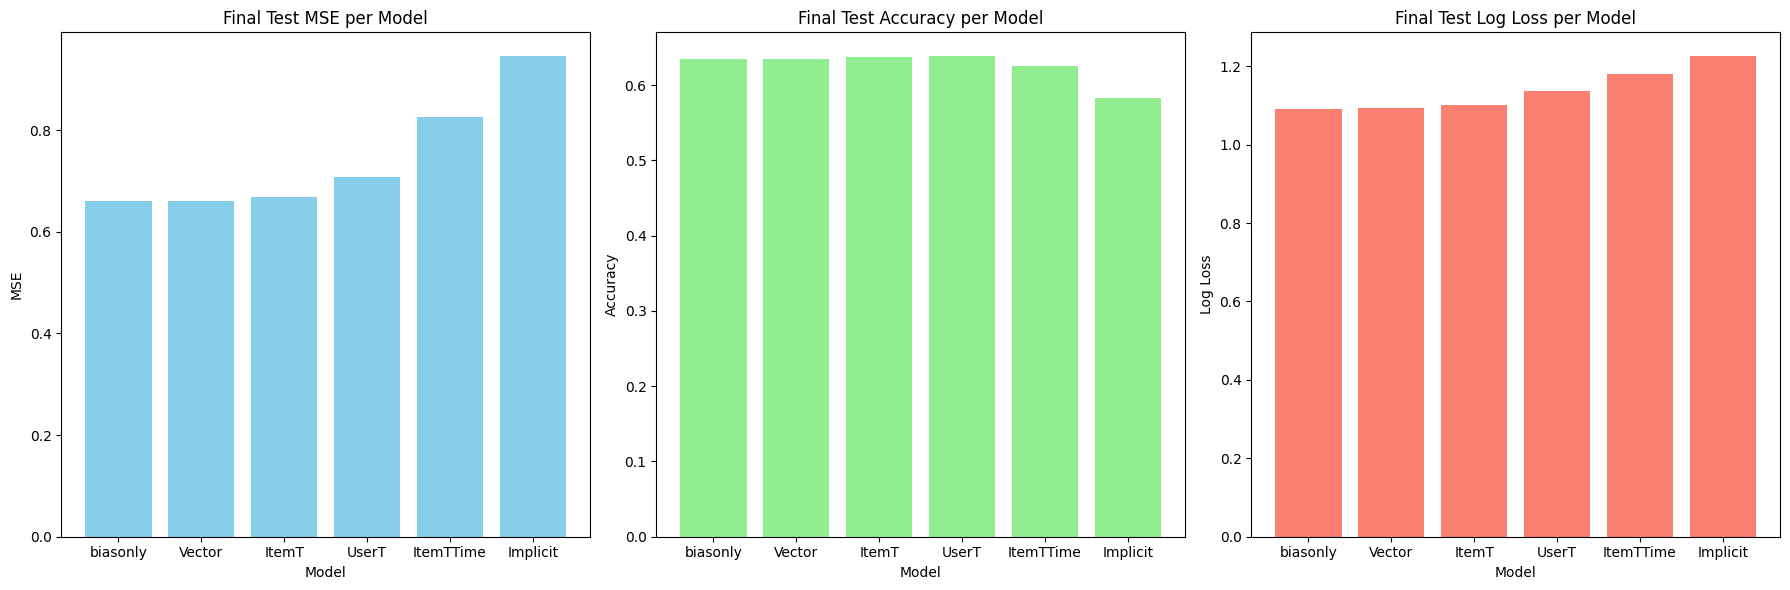

In [28]:
# Summary Bar Plots: Final Test Metrics Comparison Across All Models
# ---------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].bar(model_names, final_mse, color='skyblue')
axes[0].set_title("Final Test MSE per Model")
axes[0].set_xlabel("Model")
axes[0].set_ylabel("MSE")

axes[1].bar(model_names, final_accuracy, color='lightgreen')
axes[1].set_title("Final Test Accuracy per Model")
axes[1].set_xlabel("Model")
axes[1].set_ylabel("Accuracy")

axes[2].bar(model_names, final_log_loss, color='salmon')
axes[2].set_title("Final Test Log Loss per Model")
axes[2].set_xlabel("Model")
axes[2].set_ylabel("Log Loss")

plt.tight_layout()
plt.show()


In [29]:
os.getcwd()

'/content/drive/MyDrive/RecomendModel'